# Section X:  Generating Noise Simulations with DR4 split data.  

This Section will generate a set of simulated noise maps necessary for building power spectra convariance matrices, calculating transfer functions, and performing consistency checks. In particular, we step through the noise map prescription available in the appendix of [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf). For simplicity, we consider only one season/patch/array/freq combination (s15/D56/PA1/150 GHz), while in reality the full pipeline performs an analogous process for all such data sets.

To return to the main notebook or to view a different section use the links in the table of contents.


## Table of contents

 --- 
> [Section 1](Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb): Introduction and Importing Pixell, Healpy and other key packages

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to converted maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps.

> [Section 7](Section_7_harmonic_analysis.ipynb):  Harmonic Analysis with CAR Maps

> [Section 8](Section_8_power_spectrum.ipynb): Maps and Power Spectra of Individual Patches 

> [Section 9](Section_9_E_B_maps.ipynb):  Looks at how to generate E and B maps from I, Q, U maps. 

---

## Part 1: Import and Prepare the Data

As before, we begin by running the first notebook to import necessary packages and define the data path. Then we redefine our plotting convencience function and some handy plotting keywords to pass to enplot.plot.

In [1]:
%run Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb

def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = 'ipython')

map_kwargs = dict(downgrade = 8, ticks = 5, colorbar = True)
fourier_kwargs = dict(downgrade = (8, 24), nolabels = True, grid = False, colorbar = True)

The noise prescription utilizes "splits" of the data, which are maps generated from non-overlapping, interweaved slices of the full TOD. Each dataset (season/patch/array/frequency) has 4 splits with the exception of the AA patch, which has 2. We release maps of all splits, as well as the coadded maps for each dataset, in DR4 (see [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf), Table 2). 

Let's load the set of (4) splits for s15/D56/PA1/150 GHz, as well as the coadded map. We also load the apodized boundary window for the maps, which is common to every dataset within a given patch. The procedure for generating this boundary window is detailed in [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf).

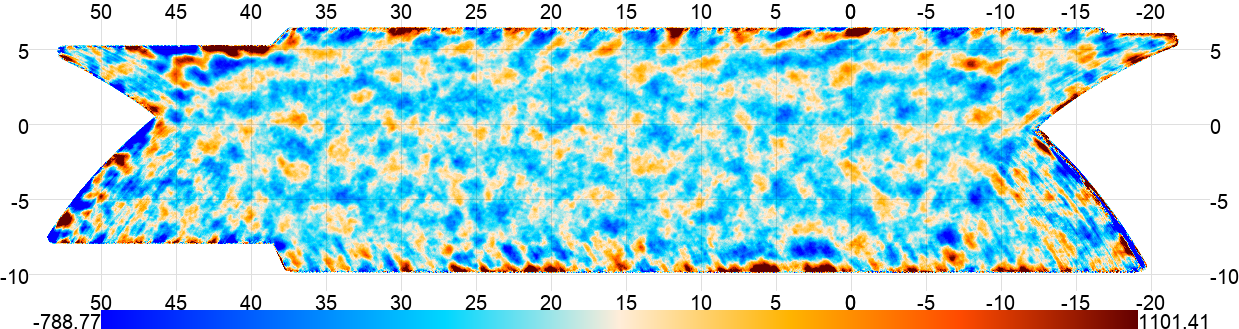

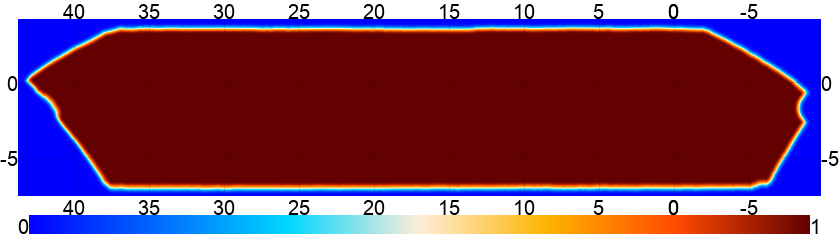

In [2]:
# Load the map-based splits and their coadd for the s15/D56/PA1 data set
splits = [enmap.read_map(path + f'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_set{i}_map_srcfree.fits') for i in range(4)]
coadd = enmap.read_map(path + 'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_coadd_map_srcfree.fits')

# Load the common boundary window for D56
window = enmap.read_map(path + 'act_dr4_D56_apo_w0.fits')

# Plot the first split I map and the window
eshow(splits[0][0], mask = 0, **map_kwargs)
eshow(window, **map_kwargs)

In general, the boundary window map has a smaller overall extent than the data maps, so we must use the enmap.extract function to ensure all our data products share the same shape and wcs. Then, we use the enmap.samewcs function to convert what would have been a list of 4 ndmap objects, each with shape (Ncomp, Ny, Nx), to a single ndmap with shape (Nsplits, Ncomp, Ny, Nx). In our case, Nsplits = 4, and Ncomp = 3 (which is almost always true).

The use of enmap.samewcs here is just aesthetic, of course, but it does showcase the utility of the ndmap object: it can hold an arbitrary number of dimensions so long as the last 3 correspond to the polarization component, the number of Y pixels, and the number of X pixels. 

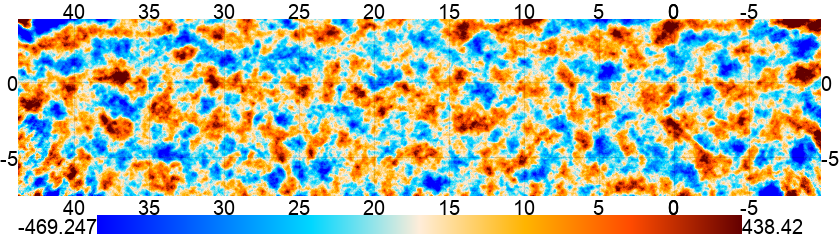

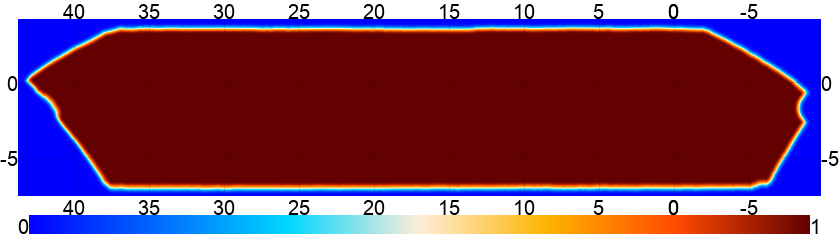

In [3]:
# Slice the splits and coadd map to ensure they align with the window
s_splits = enmap.samewcs([enmap.extract(splits[i], window.shape, window.wcs) for i in range(4)], window)
s_coadd = enmap.extract(coadd, window.shape, window.wcs)

# Plot the first split I map and the window
eshow(s_splits[0, 0], **map_kwargs)
eshow(window, **map_kwargs)

Great! If we compare the above map "extracted" map to the previous "raw" map, we see that the shape and coordinates align with the window map, which is what we wanted.

The noise prescription also requires the inverse-variance maps corresponding to the splits and the coadded map (see Table 1 of [Section 1](Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb)). Again, we use the enmap.extract function, referenced to the common boundary window, to regularize the shape and wcs of the inverse-variance maps.

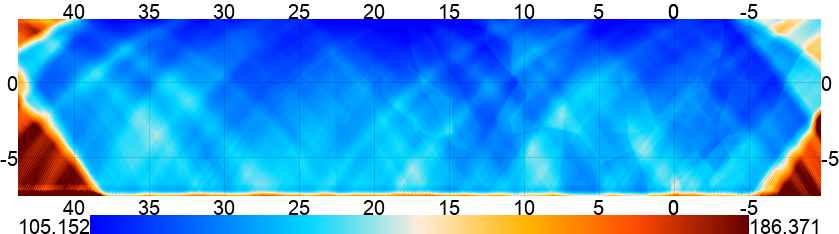

In [4]:
# Load the inverse-variance maps for the splits and for the coadd map
ivar_splits = [enmap.read_map(path + f'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_set{i}_ivar.fits') for i in range(4)]
ivar_coadd = enmap.read_map(path + 'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_coadd_ivar.fits')

# Slice the inverse-variance maps to ensure they align with the window
s_ivar_splits = enmap.samewcs([enmap.extract(ivar_splits[i], window.shape, window.wcs) for i in range(4)], window)
s_ivar_coadd = enmap.extract(ivar_coadd, window.shape, window.wcs)

# Plot the first split r.m.s. error map
eshow(1/np.sqrt(s_ivar_splits[0]), **map_kwargs)

Although in principle the inverse-variance maps contain the I, Q, U matrix elements at every pixel, as noted in [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf) we find that the matrices are well approximated by the large-hit-count, well-cross-linked limit. That is, the off diagonal covariance elements are ~0, and the Q, U *r.m.s error* elements are each ~sqrt(2) *larger* than the intensity *r.m.s. error*. Therefore, in DR4 we release only the intensity *inverse-variance* map for each split and coadd, which contains all the map-based inverse-variance information.

For this exercise we therefore need to reconstruct the polarization inverse-variance maps. 

In [5]:
def make_IQU_ivars(ivars):
    '''Copy the inverse-variance I map into an I, Q, U array'''
    ndims = len(ivars.shape)

    # I, Q, U axis in pixell is always the 3rd from the right
    expand_ivars = np.expand_dims(ivars, axis = -3)

    # We need 3 copies of the existing map along the I, Q, U axis 
    reps = np.ones(ndims+1, dtype = int)
    reps[-3] = 3

    # Copy the map and divide the Q, U inverse-variance by 2
    # Recall it is the inverse-rms of Q, U that differ by sqrt(2)
    # So factor for inverse-variance of Q, U is sqrt(2)**2 = 2
    copy_ivars = np.tile(expand_ivars, reps)
    copy_ivars[..., 1:, :, :] /= 2

    return enmap.samewcs(copy_ivars, ivars)

# Get the IQU inverse-variance maps for each split and for the coadd map
s_ivarIQU_splits = make_IQU_ivars(s_ivar_splits)
s_ivarIQU_coadd = make_IQU_ivars(s_ivar_coadd)

A quick sanity-check:

In [6]:
# For clarity the shape and wcs of everything matches up correctly
print('Splits')
print('Maps:', s_splits.shape, s_splits.wcs)
print('Ivars:', s_ivarIQU_splits.shape, s_ivarIQU_splits.wcs, '\n')
print('Coadds')
print('Maps:', s_coadd.shape, s_coadd.wcs)
print('Ivars:', s_ivarIQU_coadd.shape, s_ivarIQU_coadd.wcs, '\n')
print('Window')
print(window.shape, window.wcs)

Splits
Maps: (4, 3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}
Ivars: (4, 3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]} 

Coadds
Maps: (3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}
Ivars: (3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]} 

Window
(1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}


## Part 2: Generate Noise Power Spectra

The noise prescription takes the difference between each split map and the coadd to be an estimate of the pure noise in the data. We'll refer to these differences as "null" maps, but just to be clear, they are formally a map of the difference between the *realization* of the split-map noise and the *realization* of the coadd map noise. In general, we expect to visually see a lot of low-frequency atmospheric noise. 

So far, we have only been plotting the I map of the first split, but here we will look at the I, Q, and U maps. As you see here, the maps are released together, so calling the first of the "null" maps gives us a plot of all three components. 

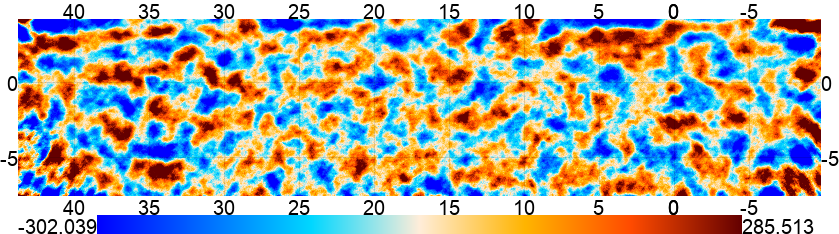

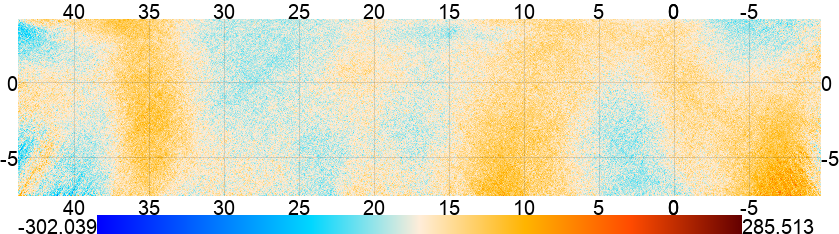

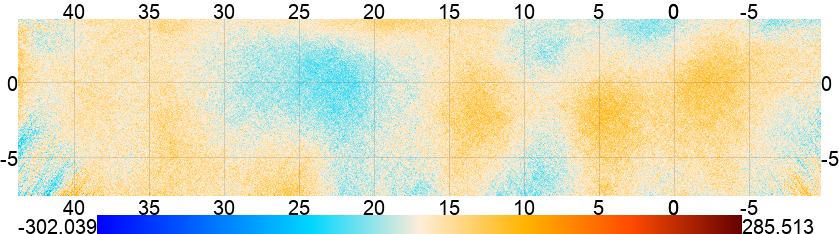

In [7]:
# Subtract the coadd map from each split map
d = s_splits - s_coadd

# Plot the first split null maps
eshow(d[0], **map_kwargs)

As an aside, we can directly check the definition of the coadd map given in [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf) -- the inverse-variance-weighted sum of the split maps. Comparing this quantity to the DR4-provided coadd map shows the two are in exceptional agreement for each of I, Q, U:

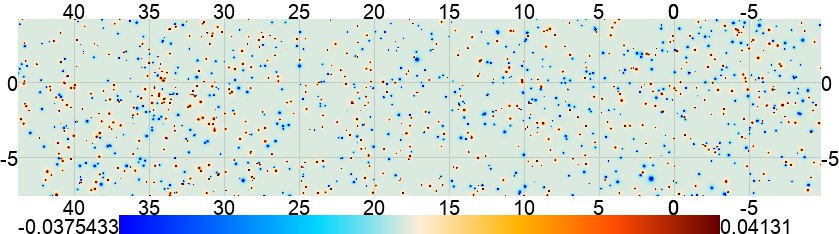

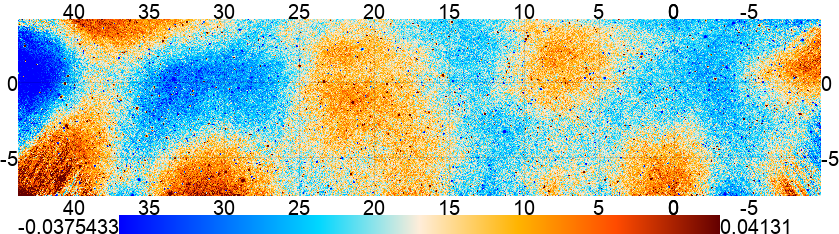

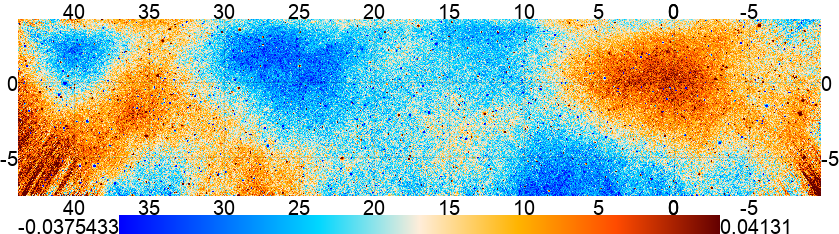

In [8]:
def make_coadd(maps, ivars):
    '''Get the coadded map from a set of split maps and their inverse-variances'''
    c = np.sum(maps * ivars, axis = 0)
    c /= np.sum(ivars, axis = 0)
    return enmap.samewcs(c, maps)

# The constructed coadd map
c = make_coadd(s_splits, s_ivarIQU_splits)

# Compare to the DR4 coadd map
eshow(c - s_coadd, **map_kwargs)


Note the colorbar is in units of $\mu K_{cmb}$, so the errors are negligible compared to the CMB anisotropy. For completeness, we use the DR4-provided coadd map in the rest of this notebook.

Anywho, back to noise sims! Our goal will be to analyze and apply the frequency content of the null maps. Before taking any Fourier transforms, we need to apply both our window and a "flattening" weight map to the null maps. The flattening weight is defined as the inverse *r.m.s. error* of the null maps and results in a map that is homogeneous and on small scales has white noise with unit variance. Based on the definition of the null map above, this turns out to be given by the below (work it out for yourself or refer to [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf)!):


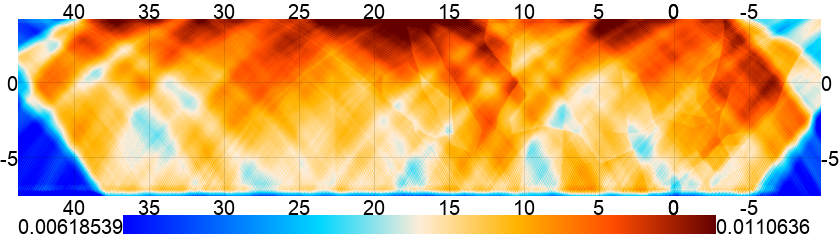

In [9]:
def make_flattening_weight(ivarIQU_splits, ivar_coadd):
    '''The inverse-rms-error for the null maps'''
    return enmap.samewcs(1/np.sqrt(1/ivarIQU_splits - 1/ivar_coadd), ivar_coadd)

# Get the flattening weights for our null maps
flattening_weight = make_flattening_weight(s_ivarIQU_splits, s_ivarIQU_coadd)

# Plot the flattening weight for the first split I map
eshow(flattening_weight[0, 0], **map_kwargs)

Now we examine the 2D Fourier power spectrum of the window-weighted, flattening-weighted null maps.

In [10]:
k_d = enmap.fft(window * flattening_weight * d, normalize = 'phys')

Because the null maps contain an *independent* realizations of the split-map noise and the *same* realization of the coadd-map noise, we define the power spectrum estimator as the following average:

In [11]:
def get_power(k_maps, a, b, window, abs = True):
    '''The 2D power spectrum for a set of fourier null maps

    a: 0, 1, or 2 for I, Q, U
    b: 0, 1, or 2 for I, Q, U
    window: apodized boundary window for the patch'''
    n = len(k_maps)
    assert n // 2 == n / 2

    # Extract I, Q, U components    
    ka_map = k_maps[:, a]
    kb_map = k_maps[:, b]

    # Get squared apodization
    w2 = np.mean(window**2)

    # Note the denominator is n*(n-1)
    power = 1/n/(n-1) * enmap.samewcs(np.sum(ka_map * np.conj(kb_map), axis = 0), ka_map)

    # Usually we only need the magnitude of the power spectrum, not its phase
    if abs:
        power = np.abs(power)

    return power / w2

Let's check out our 2D power spectra! We have 6 independent spectra from all the polarization combinations, which we'll place in a new object $P_{ab}$:

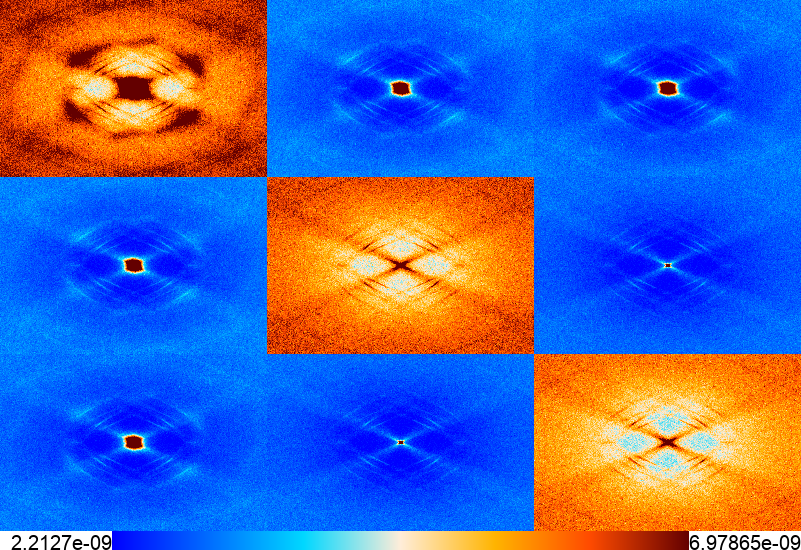

In [12]:
# The last two indices should match the shape of the (real space) map
P_ab = enmap.empty(shape = [3, 3] + list(k_d.shape[-2:]), wcs = k_d.wcs)

for i in range(3): 
    for j in range(i, 3):
        P_ab[i, j] = get_power(k_d, i, j, window)
        P_ab[j, i] = P_ab[i, j] #Symmetric matrix

# Plot the set of cross spectra in I, Q, U grid
eshow(enmap.fftshift(P_ab), tile = (3, 3), **fourier_kwargs)

As is explained in the text of [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf), the 2D power spectra are not isotropic. However, we will at least assume that the above spectra are the same at all (real-space) points within the map, up to overall magnitude. Under this assumption, each mode in a given spectrum is uncorrelated with all other modes in that spectrum (though clearly the same mode in different spectra *are* correlated!), which will facilitate generating random noise realizations later on in this notebook.

We can learn a bit more by azimuthally binning the noise spectra and examining only their $l$ dependence. We borrow the ell-binning function from [Section 7](Section_7_harmonic_analysis.ipynb):

In [13]:
def bin(data, imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized, data.reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

We plot the auto-spectra as solid lines and the cross-spectra as dashed lines:

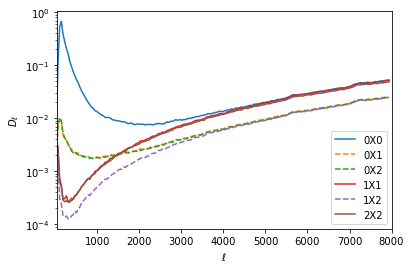

In [14]:
for i in range(3):
    for j in range(i, 3):
        if i == j: ls = '-'
        else: ls = '--'
        cents, bells = bin(P_ab[i, j], d, 8000, 40)
        plt.plot(cents, bells*cents**2./2./np.pi, ls = ls, label=f"{i}X{j}")
plt.legend()
plt.xlim(30, 8000)
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('log')

We have recovered the two primary features of the noise spectra! That is, at low $l$, there is the expected atmospheric 1/f contribution. The $l$-knee changes depending on which combination of polarization components we're looking at. At large $l$, all noise spectra hit a white-noise floor (in $D_{l}$-space white noise rises as ~$l^2$).

## Part 3: Building the Noise Covariance Matrix

Our set of 6 cross-spectra gives an estimate of the (3x3 block, symmetric) covariance matrix of the Fourier modes, whose elements carry polarization component labels (I, Q, U) *and* Fourier-index labels ($l_y$, $l_x$). Clearly, however, this estimate is itself noisy, so we would like to smooth the object in such a way as to preserve its visually-interesting features, but cut-out the high-frequency graininess. Then, we can sample from the smoothed object, which we take to be closer to the "true" noise covariance. 

There are 3 steps to generating the final noise covariance matrix, which we cover here in order:
* Radial profile fitting for $l$ > 500
* Smoothing the power spectra
* Isotropizing 2D spectra for $l$ < 300

### 3.a Radial Profile Fitting of Power Spectra ($l$ > 500)

One feature of the data we wish to preserve is its strong 1/f character at low $l$. In later steps we will apply a low-pass filter to the spectra in order to remove high-frequency noise, but due to the sharpness of the 1/f peaks, such a process is liable to cause "ringing" in the smoothed spectra. Therefore, we first remove (and store) the overall radial profile of each spectrum, and later we smooth only the "flattened" spectra.

### 3.a.1 Following the text/existing code
### I will delete this section once I can review these issues

The text says we should perform the radial fit using the spectral values only at $l$ > 500, to the form $f(\ell) = \left(\left(\frac{\ell_{knee}}{\ell}\right)^{-\alpha} + 1\right)*w$. The existing code does not jointly fit for $w$ with the other parameters; rather, it independently fixes it to the mean spectrum at large $l$. The existing code also defines large $l$ up to some $l_{max}$ of ~8000-10000, whereas there is considerable structure in these spectra at higher $l$. This seems arbitrary (?) but I don't correct for it, since in the end the fitting/smoothing procedure will still work fine. 

Following this procedure seems to not perform well generally for me, for two main reasons: (1) the $\ell_{knee}$ for the polarization cross-spectra is pretty low, and cutting the fit at $l = 500$ fails to properly capture the 1/f feature. And (2): the spectra are numerically unstable in $C_{\ell}$ space, as they are of order $10^{-9}$.

l_knee = 3000.0 +- 451.20677949067414, a = -4.0 +- 0.36371949286200894, wnoise = 0.24051947025174233$


Text(0, 0.5, 'ratio')

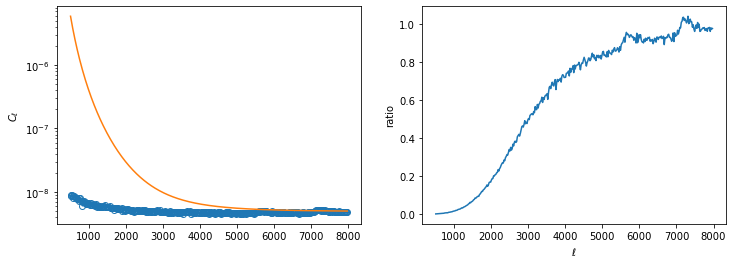

In [15]:
# Get a random spectrum
i, j = (2, 2)
x, y = bin(P_ab[i, j], k_d, 8000, 20)

# Get the white noise floor level
w = y[x > 7500].mean()
wnoise = np.sqrt(w) * (180/np.pi) * 60

###
# DEFINE THE FIT MASK
# The fit will not be performed on these values
mask = x < 500

# Define model for curve_fit
def f(x, l, a):
    return ((l/x)**-a + 1)*w

# Same bounds as the existing code
bounds = ((0, -5), (9000, 1))

# Perform the fit
# Same 'initial guess' as existing code
popt, pcov = curve_fit(f, x[~mask], y[~mask], p0 = [3000, -4], bounds = bounds)
sig = np.sqrt(np.diag(pcov))
print('l_knee = {} +- {}, a = {} +- {}, wnoise = {}$'.format(popt[0], sig[0], popt[1], sig[1], wnoise))

# Plot
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs[0].plot(x[~mask], y[~mask], marker = 'o', markerfacecolor = 'none')
axs[0].plot(x[~mask], f(x[~mask], *popt))
axs[0].set_ylabel('$C_\ell$')
axs[0].set_yscale('log')

axs[1].plot(x[~mask], y[~mask]/f(x[~mask], *popt))
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('ratio')


We see that the fit parameters don't change from their initial guess. Changing the cutoff to something lower, like $l = 200$, works a little better, but it's still not what we want:

l_knee = 2468.752914710353 +- 495.41608409644954, a = -3.1504311260624887 +- 0.27165806074763715, wnoise = 0.24051947025174233$


Text(0, 0.5, 'ratio')

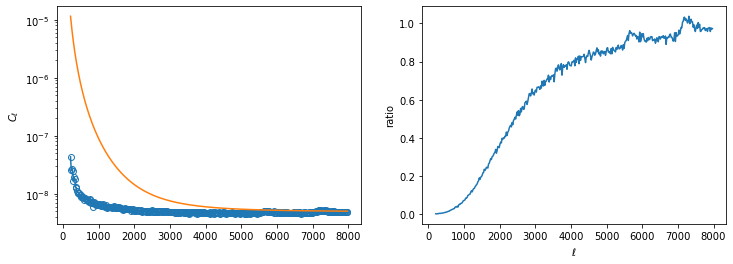

In [16]:
###
# DEFINE THE FIT MASK
# The fit will not be performed on these values
mask = x < 200

# Perform the fit
popt, pcov = curve_fit(f, x[~mask], y[~mask], p0 = [3000, -4], bounds = bounds)
sig = np.sqrt(np.diag(pcov))
print('l_knee = {} +- {}, a = {} +- {}, wnoise = {}$'.format(popt[0], sig[0], popt[1], sig[1], wnoise))

# Plot
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs[0].plot(x[~mask], y[~mask], marker = 'o', markerfacecolor = 'none')
axs[0].plot(x[~mask], f(x[~mask], *popt))
axs[0].set_ylabel('$C_\ell$')
axs[0].set_yscale('log')

axs[1].plot(x[~mask], y[~mask]/f(x[~mask], *popt))
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('ratio')

To demonstrate the numerical stability problem, if we scale everything up by a large number, we see improvements:

l_knee = 505.46015366317715 +- 6.356689017114256, a = -1.8910707772738482 +- 0.047896502135057674, wnoise = 0.24051947025174233$


Text(0, 0.5, 'ratio')

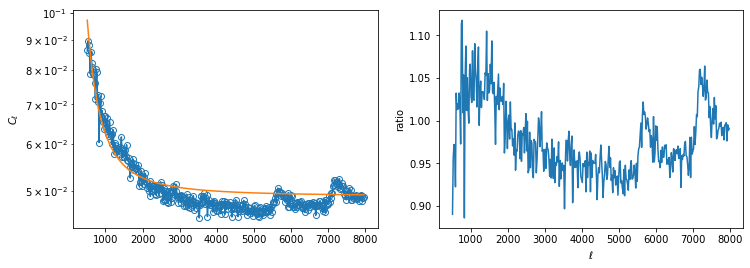

In [17]:
###
# DEFINE THE FIT MASK
# The fit will not be performed on these values
# Use the text cutoff value of l = 500
mask = x < 500

### 
# Multiply the model by some huge number
def f(x, l, a):
    return 1e7 * ((l/x)**-a + 1)*w

# Perform the fit
# Make sure to multiply y values by some huge number
popt, pcov = curve_fit(f, x[~mask], 1e7 * y[~mask], p0 = [3000, -4], bounds = bounds)
sig = np.sqrt(np.diag(pcov))
print('l_knee = {} +- {}, a = {} +- {}, wnoise = {}$'.format(popt[0], sig[0], popt[1], sig[1], wnoise))

# Plot
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs[0].plot(x[~mask], 1e7 * y[~mask], marker = 'o', markerfacecolor = 'none')
axs[0].plot(x[~mask], f(x[~mask], *popt))
axs[0].set_ylabel('$C_\ell$')
axs[0].set_yscale('log')

axs[1].plot(x[~mask], 1e7 * y[~mask]/f(x[~mask], *popt))
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('ratio')

But the existing code doesn't do this, and choosing the "big number" to scale up all the data is not a blind process. Maybe that's ok?

### 3.a.2 Modifications to text/existing code
### Will implement the 2nd one below with a review by someone else

A possibly better approach, to me, would be to perform the fit in $D_\ell$ space rather than $C_\ell$ space, since that naturally "evens out" the power spectra -- i.e., makes its y-values of similar order. This approach works even better if we lower the $l$ fit cutoff from 500 to 200, allowing us to capture to low $l_{knee}$.

l_knee = 424.63635808505904 +- 110.02470124078609, a = -3.656373051783453 +- 1.7741194415869226, wnoise = 0.24051947025174233$


Text(0, 0.5, 'ratio')

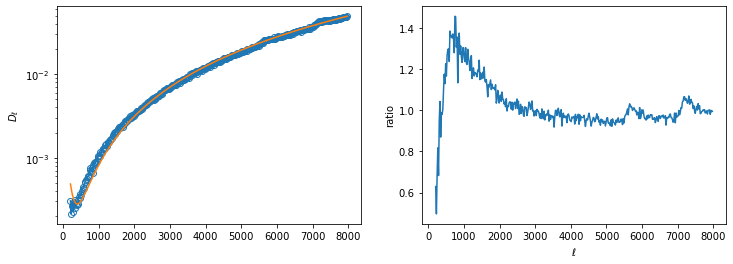

In [18]:
# Define the D_ell operator
def D(x, arr):
    return x**2*arr/2/np.pi

###
# DEFINE THE FIT MASK
# The fit will not be performed on these values
# Use the text cutoff value of l = 500
mask = x < 200

### 
# Redefine the fit function in terms of D_ell
def g(x, l, a):
    return D(x, ((l/x)**-a + 1)*w)

# Perform the fit
# Make sure to multiply y values by some huge number
popt, pcov = curve_fit(g, x[~mask], D(x[~mask], y[~mask]), p0 = [3000, -4], bounds = bounds)
sig = np.sqrt(np.diag(pcov))
print('l_knee = {} +- {}, a = {} +- {}, wnoise = {}$'.format(popt[0], sig[0], popt[1], sig[1], wnoise))

# Plot
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs[0].plot(x[~mask], D(x[~mask], y[~mask]), marker = 'o', markerfacecolor = 'none')
axs[0].plot(x[~mask], g(x[~mask], *popt))
axs[0].set_ylabel('$D_\ell$')
axs[0].set_yscale('log')

axs[1].plot(x[~mask], D(x[~mask], y[~mask])/g(x[~mask], *popt))
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('ratio')


Still, the fit quality is not as good as numerical rescaling. I think the simplest, best, blind option is to divide out the (very low) white noise level which sets the scale. If this were deployed to the actual pipeline, we would want to check that this number is not intractably small or 0, but it works here so we can run with it. 

Long story short, unlike the the existing code, we perform the fit by first dividing out the (very low) white noise floor level so that the minimization routine is not numerically unstable. NOTE: the fit was also successful if I removed the bounds in the first instance, but that I think is just another symptom of numerical instability, and bounds are a good thing, so this approach is still better:

l_knee = 505.4601534138774 +- 6.356689020595779, a = -1.8910707743810453 +- 0.04789650209947061, wnoise = 0.24051947025174233$


Text(0, 0.5, 'ratio')

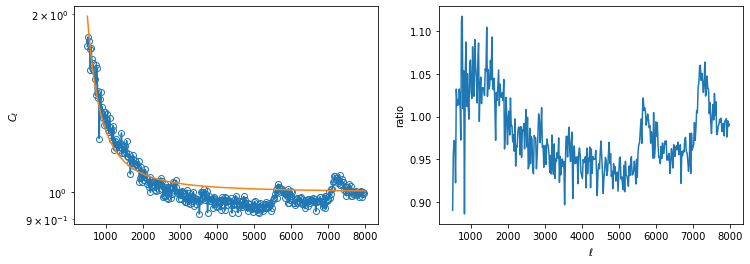

In [19]:
###
# DEFINE THE FIT MASK
# The fit will not be performed on these values
# Use the text cutoff value of l = 500
mask = x < 500

### 
# New model without white noise level
def f(x, l, a):
    return ((l/x)**-a + 1)

# Perform the fit
# Normalize y values by white noise level
popt, pcov = curve_fit(f, x[~mask], y[~mask]/w, p0 = [3000, -4], bounds = bounds)
sig = np.sqrt(np.diag(pcov))
print('l_knee = {} +- {}, a = {} +- {}, wnoise = {}$'.format(popt[0], sig[0], popt[1], sig[1], wnoise))

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
axs[0].plot(x[~mask], y[~mask]/w, marker = 'o', markerfacecolor = 'none')
axs[0].plot(x[~mask], f(x[~mask], *popt))
axs[0].set_ylabel('$C_\ell$')
axs[0].set_yscale('log')

axs[1].plot(x[~mask], y[~mask]/f(x[~mask], *popt)/w)
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('ratio')

Voila! A blind, numerically stable, simple fix.

For each azimuthally-binned spectrum, we store the best-fit parameters ($l_{knee}, \alpha, w$) and divide out the corresponding radial profile, creating a red-noise-*flattened* 2D power spectrum, which we'll keep in the object $P_{ab}^{f}$. First get the best-fit parameters:



In [41]:
# For each I, Q, U cross, hold l_knee, alpha, w
rad_params_ab = np.empty(shape = (3, 3, 3))

# New model without white noise level
def rad_fit(x, l, a):
    return ((l/x)**-a + 1)

# Define bounds on ell_knee, alpha (same as above)
bounds = ((0, -5), (9000, 1))

# Get parameters
for i in range(3):
    for j in range(i, 3):

        # Get 1d binned spectrum
        ell, c_ell = bin(P_ab[i, j], k_d, 8000, 20)

        # Get white noise level
        # Set to mean of spectrum at ell > 7500
        w = c_ell[ell > 7500].mean()

        # Define fit mask (values to be excluded), same as above
        mask = ell < 0
        ell_fit = ell[~mask]
        c_ell_fit = c_ell[~mask]

        # Perform fit
        # Normalize y values by white noise level
        rad_params_ab[i, j, :2], _ = curve_fit(f, ell_fit, c_ell_fit/w, p0 = [3000, -4], bounds = bounds)
        rad_params_ab[i, j, 2] = w
        rad_params_ab[j, i] = rad_params_ab[i, j] # Symmetric matrix

We plot the fits to be sure they all make sense:

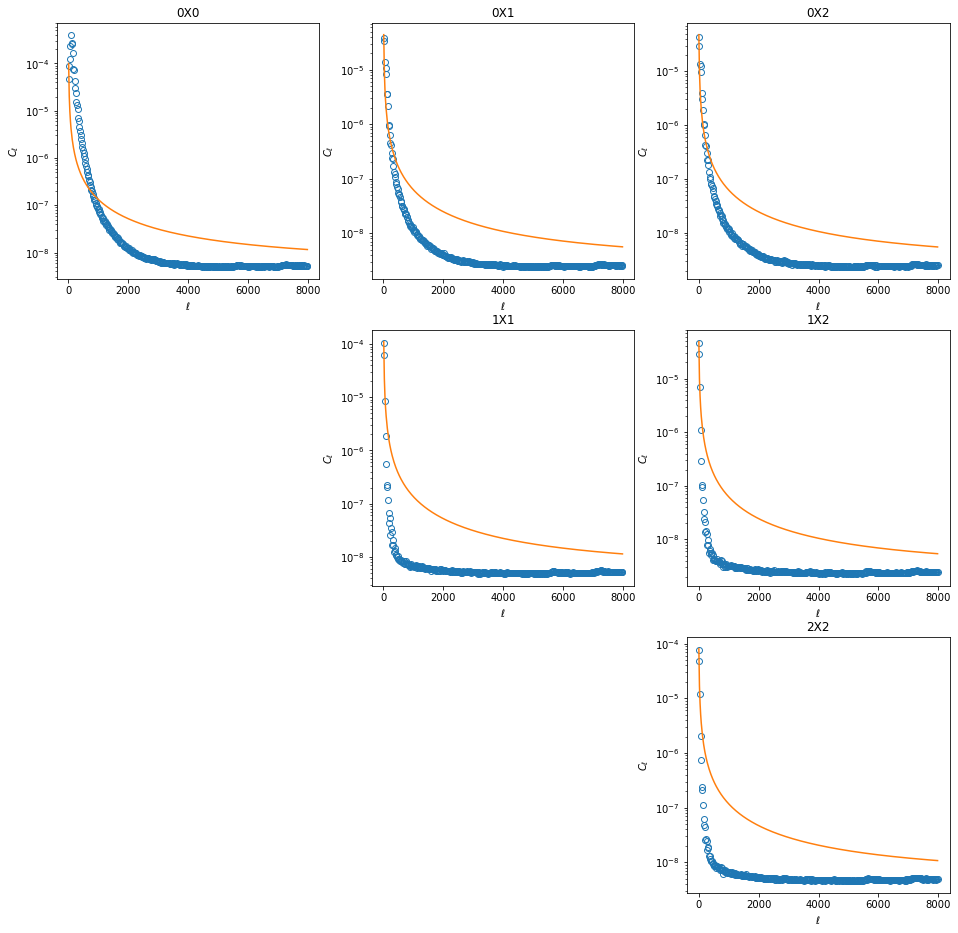

In [44]:
# Prepare plots
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 16))

# Wrapper function for plotting
def rad_fit_wrap(x, l, a, w):
    return rad_fit(x, l, a) * w
  
for i in range(3):
    for j in range(i, 3):

        # Get 1d binned spectrum
        ell, c_ell = bin(P_ab[i, j], k_d, 8000, 20)

        # Define fit mask (values to be excluded), same as above
        mask = ell < 0
        ell_fit = ell[~mask]
        c_ell_fit = c_ell[~mask]

        # Plot results
        axs[i, j].set_title(f'{i}X{j}')
        axs[i, j].plot(ell_fit, c_ell_fit, linestyle = 'none', marker = 'o', markerfacecolor = 'none')
        axs[i, j].plot(ell_fit, rad_fit_wrap(ell_fit, *rad_params_ab[i, j]))
        axs[i, j].set_xlabel('$\ell$')
        axs[i, j].set_ylabel('$C_\ell$')
        axs[i, j].set_yscale('log')
        if i is not j: axs[j, i].set_axis_off()

In [22]:
rad_params_ab[..., 0]

array([[1851.58063595, 1605.01181085, 1635.29010279],
       [1605.01181085,  478.35866886,  479.86114926],
       [1635.29010279,  479.86114926,  505.46015341]])

And we can plot the flattened 2D power spectra too:

<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)
<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)
<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)
<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)
<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)
<ipython-input-19-7c5995357b31>:10: RuntimeWarning: divide by zero encountered in true_divide
  return ((l/x)**-a + 1)


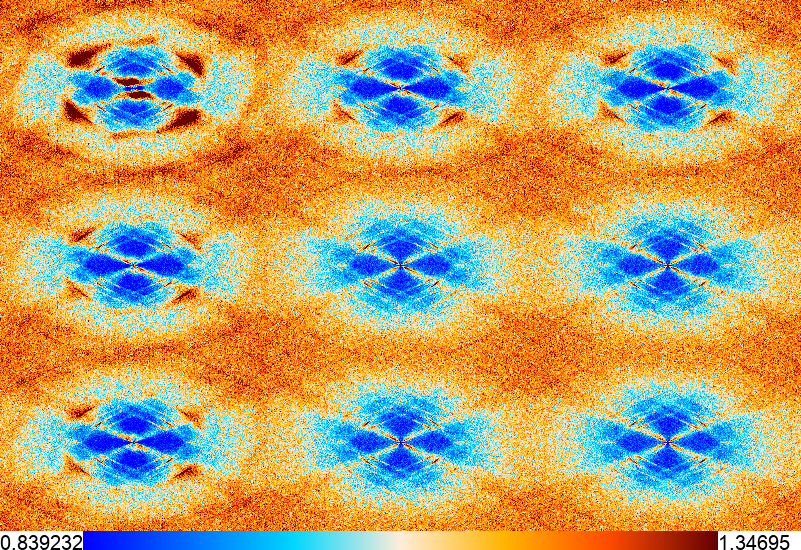

In [23]:
# The last two indices should match the shape of the (real space) map
P_ab_f = enmap.empty(shape = [3, 3] + list(k_d.shape[-2:]), wcs = k_d.wcs)

for i in range(3):
    for j in range(i, 3):
        
        # Store flattened spectra
        l, a, w = rad_params_ab[i, j]
        modlmap = window.modlmap()
        P_ab_f[i, j] = P_ab[i, j] / (f(modlmap, l, a) * w)
        P_ab_f[j, i] = P_ab_f[i, j] #Symmetric matrix

# Plot the set of cross spectra in I, Q, U grid
eshow(enmap.fftshift(P_ab_f), tile = (3, 3), **fourier_kwargs)

Looks great! We can see that all of the "whitened", a.k.a "flattened," spectra contain anisotropies which we want to keep, as well as high frequency noise which we want to smooth away.

### 3.b Power-Spectra Smoothing

Another salient feature of the 2D spectra we'd like to capture are their interesting anisotropies. Unlike the isotropic CMB, we see varying features in the 2D spectrum as we sweep around the modes in azimuth. However, there also seems to be high-frequency noise in the 2D spectra themselves -- therefore, we'd like to isolate the interesting anisotropies from the spurious graininess of the noise. We do this by smoothing the 2D power spectra.

The procedure for smoothing is fairly straightforward: we convolve each flattened 2D power spectrum with a low pass filter. In this step, we make no distinction between low and high $l$, as we did in fitting the radial profile -- the entire (flattened) 2D spectrum is smoothed altogether. 

The low-pass filter we select is a simple sigmoid-like function $f(\vec{k}) = (1 + (2|\vec{k}|D)^\beta)^{-1}$ where $\vec{k}$ are the components of the *Fourier transform of the flattened power spectrum* and $\beta$ is even. We therefore read-off the FWHM (in one dimension) of the filter as $1/D$, meaning this is *similar* to an average of a "square" of size $D$ pixels. For our region (D56), we select $D = 8$ and $\beta = 4$:


Text(0, 0.5, 'filter')

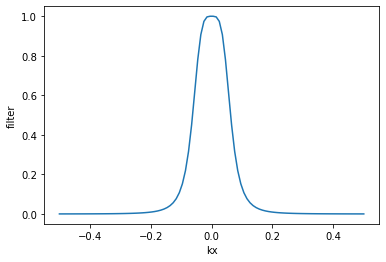

In [24]:
# Define the filter function
def make_filter_map(k, D, beta):
    '''The generic low pass filter we apply to our
    flattened 2D power spectra

    k: the Fourier mode map, with shape = (2, Ny, Nx)
    or shape = (1, N)
    D: characteristic size of filter in pixels of image space
    beta: degree of the filter
    '''
    # Get the modulus of the point in Fourier space
    modk = np.linalg.norm(np.atleast_2d(k), axis = 0)
    return 1 / (1 + (2 * modk * D)**beta)

# Plot a 1d-slice of the filter
kx = np.linspace(-0.5, 0.5, 100)
plt.plot(kx, make_filter_map(kx, 8, 4))
plt.xlabel('kx')
plt.ylabel('filter')

Note that we are essentially treating the 2D power spectra plotted in Part 3.a as any old image, and so the low-pass filter just operates in the Fourier domain of that image. It's best not to overthink it! Let's define some functions so we can do this compactly:

In [25]:
# Get a 2D "Fourier frequency" map
def fftfreq2(shape, d = 1.0):
    '''Generalize numpy.fftfreq to two dimensions'''
    assert(len(shape)) == 2

    # Get the fourier components
    # There is a Ky map and a Kx map
    ky = np.fft.fftfreq(shape[0], d = d)
    kx = np.fft.fftfreq(shape[1], d = d)

    # Place fourier components in a shape = (2, Ny, Nx) array
    k2d = np.empty((2, shape[0], shape[1]))
    k2d[0] = ky[:, None]
    k2d[1] = kx[None, :]

    return k2d

# Smooth a set of ndmaps with a filter
def smooth_maps(imaps, filter):
    '''
    imaps is a set of ndmaps with arbitrary leading dimensions
    filter is a single map with the same shape as any imap
    '''

    # Fourier transform the input maps
    k_maps = enmap.fft(imaps)

    # Multiply by our filter and inverse transform back
    return enmap.ifft(k_maps * filter).real

Now it's a few simple lines of code to emerge with our flattened, smoothed power spectra, which we'll keep in a new object called $P_{ab}^{fs}$. Recall our filter smooths $D = 8$ pixels with degree $\beta = 4$. To make it easier to see and understand the result, we also plot a much more aggressively smoothed spectrum (II) with $D = 40$:

D = 8


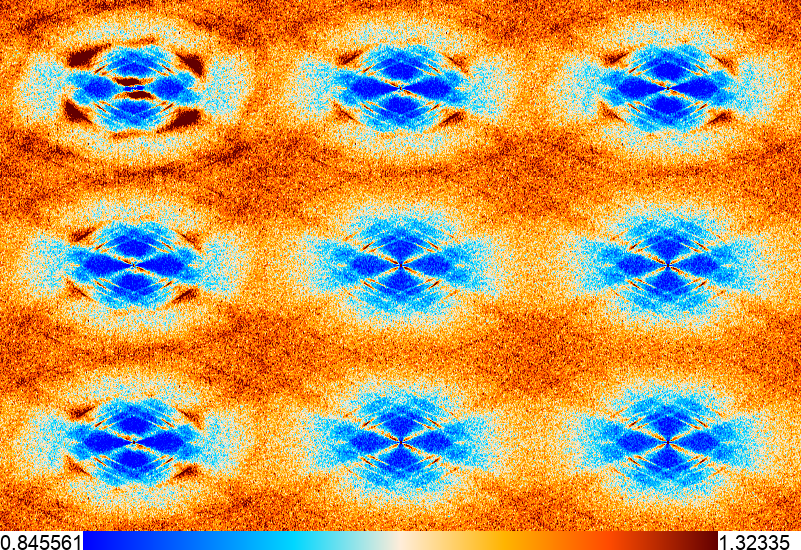

D = 40


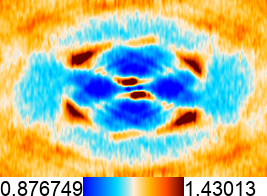

In [26]:
# Set our 2D filter parameters
D8 = 8
D40 = 40
beta = 4

# Make the fourier mode map
k2d = fftfreq2(k_d.shape[-2:])

# Make the fourier space filters
filter8 = make_filter_map(k2d, D8, beta)
filter40 = make_filter_map(k2d, D40, beta)

# Smooth our flattened power spectra
P_ab_fs = smooth_maps(P_ab_f, filter8)
P_00_fs_40 = smooth_maps(P_ab_f[0, 0], filter40)

# Plot the set of cross spectra in I, Q, U grid
print('D = 8')
eshow(enmap.fftshift(P_ab_fs), tile = (3, 3), **fourier_kwargs)

# For the II auto spectrum, demonstrate a heavily smoothed map
print('D = 40')
eshow(enmap.fftshift(P_00_fs_40), **fourier_kwargs)


Hopefully, the $D = 40$ smoothed spectrum demonstrates what's going on here. The $D = 8$ smoothed spectra appear the same as the flattened, unsmoothed in section 3.a only because we are plotting downgraded maps, as specified in "fourier_kwargs" in the beginning of the notebook. If you want, try plotting the binned power spectra now -- if you compare to before the smoothing step, you will see there really is much less white noise!

### 3.b.1 I have a suggestion/question here?

Before moving on to the last part of section 3, where we will modify the 2D power spectra "by hand" for $l$ < 300, it's useful to pause and consider what happens at low $l$.  

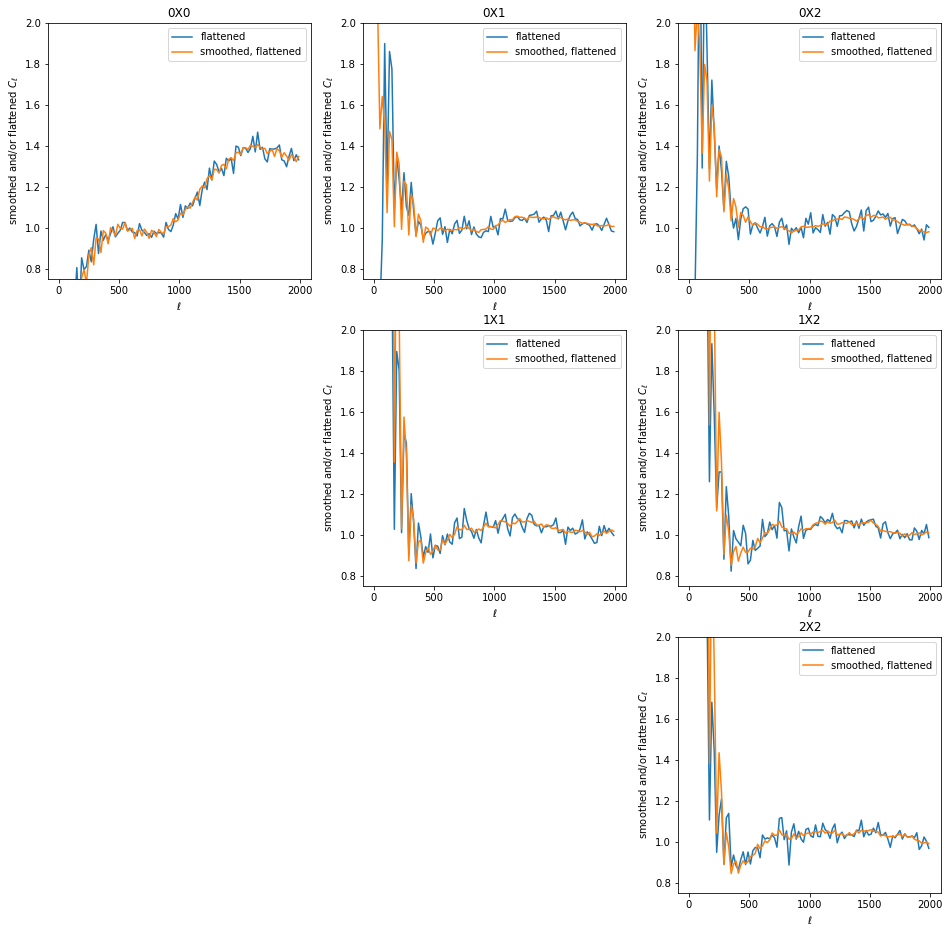

In [27]:
# Prepare plots
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 16))

for i in range(3):
    for j in range(i, 3):

        ell, c_ell_f = bin(P_ab_f[i, j], k_d, 8000, 20)
        mask = ell > 2000

        # Plot unsmoothed flat spectra, zoomed in
        axs[i, j].set_title(f'{i}X{j}')
        axs[i, j].plot(ell[~mask], c_ell_f[~mask], label = 'flattened')
        axs[i, j].set_ylim(0.75, 2)
        axs[i, j].set_xlabel('$\ell$')
        axs[i, j].set_ylabel('flattened $C_\ell$')

        # Plot smoothed flat spectra, zoomed in
        _, c_ell_s = bin(P_ab_fs[i, j], k_d, 8000, 20)
        axs[i, j].plot(ell[~mask], c_ell_s[~mask], label = 'smoothed, flattened')
        axs[i, j].set_ylim(0.75, 2)
        axs[i, j].set_xlabel('$\ell$')
        axs[i, j].set_ylabel('smoothed and/or flattened $C_\ell$')
        axs[i, j].legend()
        if i is not j: axs[j, i].set_axis_off()


### 3.c Isotropizing the 2D Power Spectra ($l$ < 300)

Finally, in our noise prescription, we "isotropize" the 2D spectra for the smallest modes. We claim that because the number of modes at low $l$ is small, any anisotropies there are more likely statistical variations (or data processing artifacts) than real features of the "true" covariance matrix. Therefore, we replace each (flattened, smoothed) 2D spectrum (for $l$ < 300) with an azimuthally-symmetric form $P_{ab}^{fs}(\vec{l}) = Ae^{-l_0/|\vec{l}|} + B$.

To get the best-fit parameters for each 2D spectrum, we fit to the flattened, *unsmoothed* spectrum, using an $l$ range up to $l = 600$. We can borrow the code from part 3.a when we fit the radial profile at $l$ > 500. Due to the smaller $l$-range of the fit, we decrease the binsize from 20 to 10: 

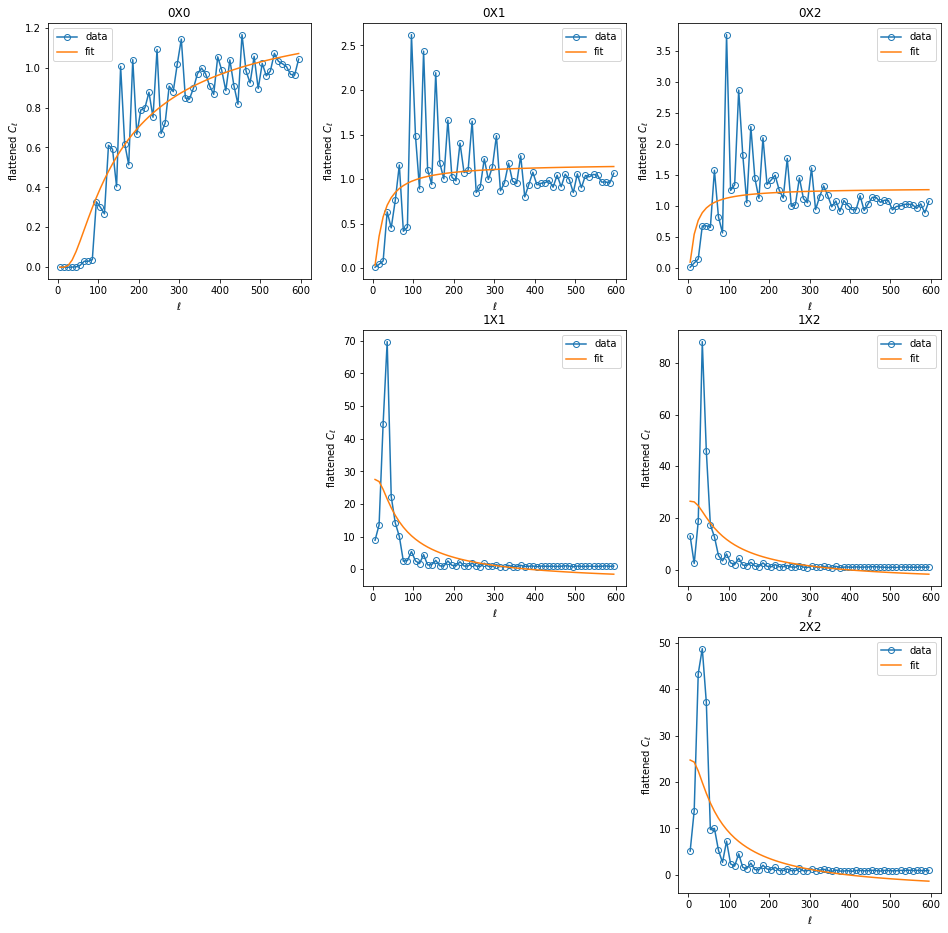

In [28]:
# For each I, Q, U cross, hold l0, A, B
iso_params_ab = np.empty(shape = (3, 3, 3))

# Isotropic model that will replace the spectra at low ell
def iso_fit(x, l0, A, B):
    return A*np.exp(-l0/x) + B

# Define bounds on l0, A, B
bounds = ((2, -np.inf, 0), (600, np.inf, np.inf))

# Prepare plots
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 16))

# Get parameters
for i in range(3):
    for j in range(i, 3):

        # Get 1d binned spectrum from flattened spectra
        ell, c_ell = bin(P_ab_f[i, j], k_d, 8000, 10)

        # Define fit mask (values to be excluded)
        mask = ell > 600
        ell_fit = ell[~mask]
        c_ell_fit = c_ell[~mask]

        # Perform fit
        iso_params_ab[i, j], _ = curve_fit(iso_fit, ell_fit, c_ell_fit, p0 = [20, 1, 0], bounds = bounds)
        iso_params_ab[j, i] = iso_params_ab[i, j] # Symmetric matrix

        # Plot results
        axs[i, j].set_title(f'{i}X{j}')
        axs[i, j].plot(ell_fit, c_ell_fit, marker = 'o', markerfacecolor = 'none', label = 'data')
        axs[i, j].plot(ell_fit, iso_fit(ell_fit, *iso_params_ab[i, j]), label = 'fit')
        axs[i, j].set_xlabel('$\ell$')
        axs[i, j].set_ylabel('flattened $C_\ell$')
        axs[i, j].legend()
        if i is not j: axs[j, i].set_axis_off()

Finally, we put all the pieces together to emerge with our full map-space noise covariance matrix for the D56 patch! In order:
* For each cross, replace the $l < 300$ range of the 2D *smoothed, flattened* spectrum with our isotropic fit (which is by definition pretty smooth). We can store this in a new object $P_{ab}^{fsr}$, with the "r" for "replaced"
* For each cross, multiply the new smoothed, flattened spectrum by the radial fit for that spectrum
* For each cross, replace the "0" mode with the value 0

The last point is necessary because a true noise map should have no DC power! We'll store the covariance matrix in the object $C_{ab}$:

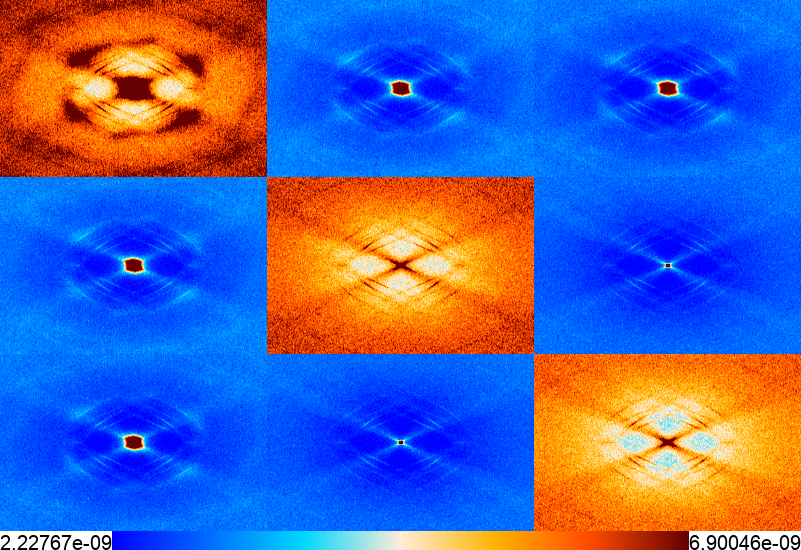

In [38]:
# The last two indices should match the shape of the (real space) map
C_ab = enmap.empty(shape = P_ab_fs.shape, wcs = k_d.wcs)

# New object holds smooth, flat spectra with isotropic replacement at low ell
P_ab_fsr = P_ab_fs.copy()

# Get the mask for the isotropic low-ell replacement
# These values will be left alone
modlmap = window.modlmap()
modlmap[..., 0, 0] = 1e-14  #Avoid divide by 0 errors
mask = modlmap > 300

for i in range(3):
    for j in range(i, 3):

        # Replace the low ell portion of each 2D spectrum
        P_ab_fsr[i, j, ~mask] = iso_fit(modlmap[~mask], *iso_params_ab[i, j])

        # Multiply the flattened smoothed spectra by the radial fit
        C_ab[i, j] = P_ab_fsr[i, j] * rad_fit_wrap(modlmap, *rad_params_ab[i, j])
        C_ab[j, i] = C_ab[i, j] #Symmetric matrix
    
# Set DC power -- (ly, lx) = (0, 0) -- for all spectra to 0
C_ab[..., 0, 0] = 0

# Show the covariance matrix in I, Q, U grid
eshow(enmap.fftshift(C_ab), tile = (3, 3), **fourier_kwargs)

In [31]:
test = np.moveaxis(C_ab.copy(), (0, 1), (2, 3))
import time
t0 = time.time()
testsub = test[:,:]
w, v = np.linalg.eig(testsub)
t1 = time.time()
print((t1 - t0) * test.size/testsub.size)


28.75503921508789


In [40]:
import time
t0 = time.time()
testsub = C_ab[:,:]
sqrtC_ab = enmap.multi_pow(testsub, 0.5)
t1 = time.time()
print((t1 - t0) * C_ab.size/testsub.size)


72.87749695777893


Hooray! We are *almost* ready to generate on-the-fly noise simulations.

## Intermission: The Sqrt-Covariance Matrix

In [ ]:
m = np.zeros(2)
c = np.array([[0, 1],[1, 0]])
samps = np.random.multivariate_normal(m, c, size = 1000)
x, y = samps.T
plt.scatter(x, y)